# ANOVA

Last week we did a deep dive into Analysis of Variance.  After this hands-on exercise we have a better understanding of the underlying process which allows us to draw conclusions about the liklihood that various samples came from different populations.

Today we'll explore a multi-factor data set. We'll start out with some basic exploratory data analysis, then we'll apply our knowledge of t-tests and one-way ANOVA to each of the factors.  Finally we'll acount for both factors with a two-way ANOVA and apply a post-hoc test to determine which of our factors are significant.

The data set contains some plant growth data.  Plant height was measured for several groups. Both watering schedule and sunlight intensity were varied in the experiment.  The goal is the see if watering frequency and sunlight intensity affect the final height of the plant.

Lets get some libraries!

In [72]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats as st
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

**Load the data**

Put the `plants.csv` file into your current directory and load it into a pandas DataFrame. If you forget the method, either do a search for it or use a previous studio.

In [73]:
def path_finder(file_name):
    
    directory = os.path.dirname('__file__')
    file_directory = os.path.join(directory, file_name)
       
    file_path = file_directory
    
    try:
        csv_read = pd.read_csv(file_path)
    
    except Exception as e:
        print('Failed to load data')
        print(f'Error: {e}')
        csv_read = None
        
    return csv_read

def data_sorter(data):
    
    grouped_data = {}
    
    for _, row in data.iterrows():
        
        water = row['water']
        sun = row['sun']
        height = row['height']
        
        key = (water, sun, height)
    
        if key not in grouped_data:
            grouped_data[key] = []
            
        grouped_data[key].append(row.to_dict())
        
    return grouped_data

def data_analyzer(data):
    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    analysis_results = {}
    
    for key, rows in data.items():
        
        water, sun, height = key
        key = (water, sun, height)

        df = pd.DataFrame(rows)
        
        stats = {
            'water mean' : df['water'].mean(skipna=True),
            'water stdev' : df['water'].std(skipna=True),
            'water median' : df['water'].median(skipna=True),
            'sun mean' : df['sun'].mean(skipna=True),
            'sun stdev' : df['sun'].std(skipna=True),
            'sun median' : df['sun'].median(skipna=True),
            'height mean' : df['height'].mean(skipna=True),
            'height stdev' : df['height'].std(skipna=True),
            'height median' : df['height'].median(skipna=True),
            'Sample Size': len(df)
        }
        
        stats = {k: float(v) if isinstance(v, np.float64) else v for k, v in stats.items()}
        
        analysis_results[key] = stats
        
    return analysis_results

# Name of CSV file
file_name = 'plants.csv'

# Gets the data from the CSV
plants_data = path_finder(file_name)

# Sorts the data from the CSV
sorted_plants_data = data_sorter(plants_data)

daily_height = plants_data[plants_data['water'] == 'daily']['height']
weekly_height = plants_data[plants_data['water'] == 'weekly']['height']

In [74]:
# Two-sample t-test using SciPy
t_stat, p_val = st.ttest_ind(daily_height, weekly_height, equal_var=False)
print(f"t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")

t-statistic: 2.4400, p-value: 0.0220


**Explore the data**

Have a look at the DataFrame.  How many columns are there?  What kind of data is in each column?  How many unique values are in the categorical columns?



In [75]:
# Show the first few rows and info about the DataFrame
print(plants_data.head())
print("\nDataFrame info:")
print(plants_data.info())

# Unique values in categorical columns
print("\nUnique values in 'water':", plants_data['water'].unique())
print("Unique values in 'sun':", plants_data['sun'].unique())

   water  sun  height
0  daily  low       6
1  daily  low       6
2  daily  low       6
3  daily  low       5
4  daily  low       6

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   water   30 non-null     object
 1   sun     30 non-null     object
 2   height  30 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 852.0+ bytes
None

Unique values in 'water': ['daily' 'weekly']
Unique values in 'sun': ['low' 'med' 'high']


Create a boxplot which has plant height on the y-axis and watering schedule on the x-axis.  

The Seaborn library is the natural choice (lookup the boxplot function), but feel free to use library you wish. Just remember to import the associated library.

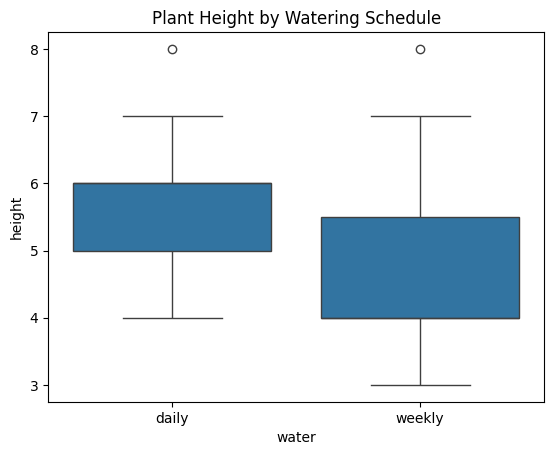

In [76]:
sn.boxplot(x='water', y='height', data=plants_data)
plt.title('Plant Height by Watering Schedule')
plt.show()

Now create a second box plot with plant height on the y-axis and sun intensity on the x-axis.  Take note of any differences.

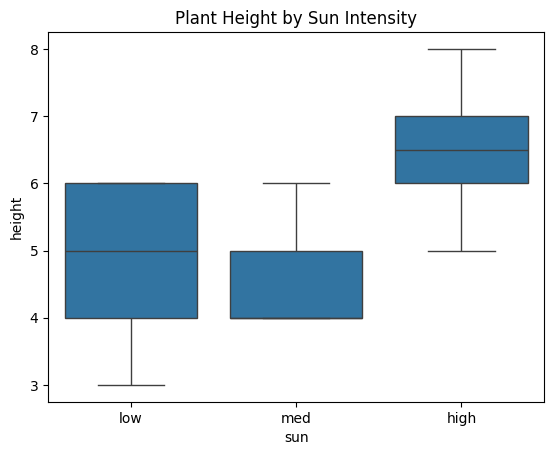

In [77]:
sn.boxplot(x='sun', y='height', data=plants_data)
plt.title('Plant Height by Sun Intensity')
plt.show()

## Comparing daily vs weekly

First we'll look at the difference between watering schedules only.  Since there are only two levels to this factor, we can split the height data into two samples.  

First we'll isolate the "daily" data using a boolean index, then we'll grab the height values from that sample.

```
daily_idx = df["water"] == "daily"
daily_height = df[daily_idx]["height"]
```

NOTE: If 'df' doesn't work, use whichever variable you chose to load the data with.

In [78]:
daily_height = plants_data[plants_data['water'] == 'daily']['height']
weekly_height = plants_data[plants_data['water'] == 'weekly']['height']
print("Daily heights:", daily_height.values)
print("Weekly heights:", weekly_height.values)

Daily heights: [6 6 6 5 6 5 5 6 4 5 6 6 7 8 7]
Weekly heights: [3 4 4 4 5 4 4 4 4 4 5 6 6 7 8]


Now, create corresponding weekly height values.

In [79]:
# done above

Get our function from a couple weeks ago to do our two sample t-test, and we will compare it to the built-in method from SciPy.

```
st.ttest_ind(sample_1,sample_2)
```

Perform both tests on the two different samples. For the SciPy method, rembember to replace 'sample_1' and 'sample_2' with the variables you created.

In [80]:
def manual_ttest(sample1, sample2):
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)

    t_num = mean1 - mean2
    t_den = np.sqrt(var1/n1 + var2/n2)
    t_stat = t_num / t_den

    df = (var1/n1 + var2/n2)**2 / ((var1**2)/((n1**2)*(n1-1)) + (var2**2)/((n2**2)*(n2-1)))

    p_val = 2 * st.t.sf(np.abs(t_stat), df)
    return t_stat, p_val


t_manual, p_manual = manual_ttest(daily_height, weekly_height)
print(f"Manual t-test: t = {t_manual:.4f}, p = {p_manual:.4f}")


t_scipy, p_scipy = st.ttest_ind(daily_height, weekly_height, equal_var=False)
print(f"SciPy t-test: t = {t_scipy:.4f}, p = {p_scipy:.4f}")

Manual t-test: t = 2.4400, p = 0.0220
SciPy t-test: t = 2.4400, p = 0.0220


Just for fun, let's compare this value to a one-way ANOVA using just the two samples.

```
st.f_oneway(sample_1,sample_2)
```

In [81]:
# One-way ANOVA for daily vs weekly watering
f_stat, p_val = st.f_oneway(daily_height, weekly_height)
print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")

ANOVA F-statistic: 5.9535, p-value: 0.0213


Notice how the p-values are the same?  For two samples these methods are actually identical.  If we are doing the manual calculation it's a little easier to do the t-test, but if we wanted to do the algebra we could prove that they are actually calculating the same thing.

So why do we have ANOVA?  As we saw last week we will often want to look at more than two samples.  In this case, doing multiple t-tests will increase our liklihood of Type I error.  The methods are not equivelent when there are more than two samples.

## Comparing sunlight intensity

This factor has three levels, so we will have to perform an ANOVA to find our significance.  

Just like we did for daily and weekly, isolate the data for each of the three levels ("low", "med", and "high") and perform a one-way ANOVA on the height.



In [82]:
low_height = plants_data[plants_data['sun'] == 'low']['height']
med_height = plants_data[plants_data['sun'] == 'med']['height']
high_height = plants_data[plants_data['sun'] == 'high']['height']


f_stat_sun, p_val_sun = st.f_oneway(low_height, med_height, high_height)
print(f"Sunlight ANOVA F-statistic: {f_stat_sun:.4f}, p-value: {p_val_sun:.4f}")

Sunlight ANOVA F-statistic: 14.1050, p-value: 0.0001


### Basic two-way ANOVA

But what happens when we want to look at both factors?  Afterall it's reasonably to think that they could both have an effect.  

In this case we need a two-way ANOVA.  We are not going to dive into the math of the two-way ANOVA, but it basically works the same as the one way.  We are ultimately comparing in-group variance to between-group variance.

The syntax is a little weird.  Just go with it.

```
model = ols('height ~ C(water) + C(sun)', data=df).fit()
sm.stats.anova_lm(model, typ=2)
```

You can google the `anova_lm` function to read about the input.  Or if you search for "two-way ANOVA Python" you'll find a lot of articles.  ANOVA is one of the most widely used statistical techniques so it's well documented.

In [83]:
model = ols('height ~ C(water) + C(sun)', data=plants_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

             sum_sq    df          F    PR(>F)
C(water)   8.533333   1.0  14.532751  0.000762
C(sun)    24.866667   2.0  21.174672  0.000003
Residual  15.266667  26.0        NaN       NaN


### Two-way ANOVA with factor interaction

We just looked at the influence of both factors on the height, but what about the "factor interaction"?  What if the intense sunlight allows the plant to use more water, or if the daily watering schedule allowed the plant to more efficiently utilize the sunlight?  This would create a factor interact, where changing both of those variables together produced an outcome that was different than the effect of changing each one independently.

We basically use the same cyntax as before, but we add a term for water-sun interaction like this:

`model = ols('height ~ C(water) + C(sun) + C(water):C(sun)', data=df).fit()`
`sm.stats.anova_lm(model, typ=2)`


In [84]:
model_inter = ols('height ~ C(water) + C(sun) + C(water):C(sun)', data=plants_data).fit()
anova_table_inter = sm.stats.anova_lm(model_inter, typ=2)
print(anova_table_inter)

                    sum_sq    df        F    PR(>F)
C(water)          8.533333   1.0  16.0000  0.000527
C(sun)           24.866667   2.0  23.3125  0.000002
C(water):C(sun)   2.466667   2.0   2.3125  0.120667
Residual         12.800000  24.0      NaN       NaN


We can see that we do not get a significant p-value for the interaction, so we cannot conclude that there is likely to be an additional effect when we change the level of both factors.

## Post-hoc

The ANOVA we just performed told us that there was liekly to be a difference between our populations, but it did not tell us *which* populations were likely to be different.  For that we need to do a post-hoc test.

We will use a basic test called *Tukey's range test* which is also often called *Tukey's HSD (honestly signficant difference) test*.

In this case we're going to skip the math altogether.  Just try the analysis.

`tukey = pairwise_tukeyhsd(endog=df['height'],groups=df['sun'],alpha=0.05)`       

`print(tukey)`


In [85]:
# Tukey's HSD post-hoc test for sunlight intensity
tukey_sun = pairwise_tukeyhsd(endog=plants_data['height'], groups=plants_data['sun'], alpha=0.05)
print(tukey_sun)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
  high    low     -1.7 0.0011 -2.741 -0.659   True
  high    med     -2.1 0.0001 -3.141 -1.059   True
   low    med     -0.4 0.6124 -1.441  0.641  False
--------------------------------------------------


Now try it for the watering schedule.

In [86]:
# Tukey's HSD post-hoc test for watering schedule
tukey_water = pairwise_tukeyhsd(endog=plants_data['height'], groups=plants_data['water'], alpha=0.05)
print(tukey_water)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 daily weekly  -1.0667 0.0213 -1.9622 -0.1712   True
----------------------------------------------------
